In [ ]:
!pip install --upgrade networkx

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.imagesource {
    font-size: xx-small;
}
</style>
""")

from datascience import *

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

import networkx as nx

## Working with complete network data

To review, in our study of personal networks, we focused on individuals. Starting from a sample of individuals, we gathered information about other people connected to those individuals. 

Today, we will work with a different kind of network data, an entire population of individuals and all of the connections between them. I'll refer to this as the *complete network perspective*. The complete network perspective can be very useful, since it enables us to study how the actual structure of the network can affect important outcomes like the spread of a disease, information about job openings, and even social status.

For almost any social network we study, we are interested in understanding the structure of the complete network. Unfortunately, it is typically extremely difficult to obtain complete network data. Most studies that have done so have put a tremendous amount of time, effort and resources into data collection.  Any time we analyze data---including complete network data---we have to bear in mind the strengths and limitations of the way that the data were collected.

### The Add Health Study

For our first complete network dataset, we're going to be looking at data from a study called [Add Health](http://www.cpc.unc.edu/projects/addhealth). Here is a description of the study, taken from the front page of the [Add Health website](http://www.cpc.unc.edu/projects/addhealth):

<blockquote>
The National Longitudinal Study of Adolescent to Adult Health (Add Health) is a longitudinal study of a nationally representative sample of adolescents in grades 7-12 in the United States during the 1994-95 school year. The Add Health cohort has been followed into young adulthood with four in-home interviews, the most recent in 2008, when the sample was aged 24-32. Add Health is re-interviewing cohort members in a Wave V follow-up from 2016-2018 to collect social, environmental, behavioral, and biological data with which to track the emergence of chronic disease as the cohort moves through their fourth decade of life.
<BR><BR>
Add Health combines longitudinal survey data on respondents’ social, economic, psychological and physical well-being with contextual data on the family, neighborhood, community, school, friendships, peer groups, and romantic relationships, providing unique opportunities to study how social environments and behaviors in adolescence are linked to health and achievement outcomes in young adulthood. The fourth wave of interviews expanded the collection of biological data in Add Health to understand the social, behavioral, and biological linkages in health trajectories as the Add Health cohort ages through adulthood, and the fifth wave of data collection continues this biological data expansion.
</blockquote>

Here are some terms from that description that might not be familiar to you:

* `longitudinal` - logitudinal studies follow people over time, instead of just interviewing people at one point in time
* `cohort` - a group of people that is followed over time; for Add Health, the cohort is the group of people who were interviewed as 7-12th graders in 1994-95.
* `nationally representative` - the participants in the study were chosen in a principled way that enables researchers to make inferences about the US population from the small number of people they interview

Add Health interviewed adolescents in many different schools that were randomly sampled from all over the US. We're going to work with the data from the friendship network of students in just one of those schools today.  

**NOTE:** We're not working with the research version of the Add Health dataset. (You have to apply for that.) We're working with a simplified version that was described as part of the UCINET software package.

Now that we have some background, we'll need to talk a bit about some of the technical details that go into working with complete network data.

### Representing a network in a computer

**Discussion question** 

Take a moment to think: how can we turn a network -- which we have been thinking of an abstract concept -- into something concrete that we can store and manipulate in a computer? What information do we need to be able to describe everything about a network? What are the advantages and disadvantages of the different solutions you can think of?

[Class discussion]

Two main ideas:

1. an edge list
2. an adjacency matrix

There are tradeoffs between the two different approaches: since almost all social networks are *sparse* (there are relatively few edges, compared to the maximum number of possible edges), the edge list approach tends to take less space than the adjacency matrix approach.

On the other hand, the adjacency matrix can be faster to access once it's in memory, and it's much more convenient to work with mathematically.

So there are advantages and disadvantages to representing a network either way.  The datasets we will encounter in this class will almost all be stored using edge lists.

### Loading a complete network

We will be exploring friendships from an American school; the data can be found at [http://moreno.ss.uci.edu/data.html#adhealth](http://moreno.ss.uci.edu/data.html#adhealth).

The data are in [UCI format](https://gephi.org/users/supported-graph-formats/ucinet-dl-format/). [UCI](https://sites.google.com/site/ucinetsoftware/home) is a tool that can be used to perform all sorts of network analysis. We won't be using UCI in this class, but you might come across it in future classes. For now, we're interested in some of the data that are included with UCI. These UCI datasets contain edge lists which the Python package `networkx` can read in.

The code below opens up the data file, but just reads it as lines of text (instead of interpreting the lines of text as a description of a network).<BR>

Run the code chunk below, and take a look at its output.

In [2]:
# this file was downloaded from
# http://moreno.ss.uci.edu/data.html#adhealth
edge_file = "comm1.dat"
with open(edge_file, 'r') as f:
    edge_lines = f.readlines()

In [3]:
edge_lines

['DL\n',
 'N=71\n',
 'FORMAT=EDGELIST1\n',
 'DATA:\n',
 '        1     52  1.00\n',
 '        2     20  1.00\n',
 '        2     27  1.00\n',
 '        2     33  2.00\n',
 '        2     45  1.00\n',
 '        2     46  1.00\n',
 '        2     57  2.00\n',
 '        2     59  2.00\n',
 '        2     62  2.00\n',
 '        2     69  1.00\n',
 '        3      6  2.00\n',
 '        3     29  1.00\n',
 '        3     34  1.00\n',
 '        3     40  2.00\n',
 '        6      3  2.00\n',
 '        6     19  2.00\n',
 '        6     26  2.00\n',
 '        6     40  3.00\n',
 '        6     47  1.00\n',
 '        7     13  2.00\n',
 '        7     15  4.00\n',
 '        7     21  1.00\n',
 '        7     33  1.00\n',
 '        7     42  1.00\n',
 '        7     65  1.00\n',
 '        8      5  1.00\n',
 '        8     14  1.00\n',
 '        8     18  1.00\n',
 '        8     23  6.00\n',
 '        8     35  1.00\n',
 '        8     38  3.00\n',
 '        8     60  1.00\n',
 '        9      

Note that it looks like there are 4 extraneous lines at the top of the file before the edge list starts. Fortunately, the `networkx` package is smart enough to skip these four lines. 

In order to understand how the data are formatted, read the "Description" section of the [website](http://moreno.ss.uci.edu/data.html#adhealth) where the data can be downloaded. It turns out that the fields are:

* first number - id of first node involved in edge
* second number - id of second node involved in edge
* third number - number of activities the two students participated in together

In order to convert the edgelist contained in the datafile into a `networkx` object, we use the `nx.parse_edgelist` function:

In [4]:
g = nx.parse_edgelist(edge_lines, nodetype=int, data=[('activity_level', float)])

You can see some more information about how this function works by looking at the help file:

In [ ]:
nx.parse_edgelist?

In addition to the lines from the datafile, we also passed a couple other arguments to the `parse_edgelist` function. They are:

* `nodetype` - specifies the Python type used to represent each node. We have integer ids, so we use `int` here
* `data` - describes any extra information about each edge that is contained in the edge list; in our case, there is a floating point value that describes the amount of interaction an edge represents. See the [data description](http://moreno.ss.uci.edu/data.html#adhealth) and the `parse_edgelist` help file for more information

Now that we have read our edgelist into a `networkx` object, we can start to investigate this network.

For example, we can list the edges in the network:

In [5]:
g.edges()

EdgeView([(1, 36), (1, 52), (1, 37), (2, 33), (2, 59), (2, 20), (2, 62), (2, 57), (2, 27), (2, 45), (2, 46), (2, 69), (3, 40), (3, 34), (3, 29), (3, 6), (5, 8), (5, 44), (5, 38), (5, 14), (6, 19), (6, 40), (6, 26), (6, 47), (7, 33), (7, 21), (7, 65), (7, 24), (7, 42), (7, 13), (7, 15), (8, 18), (8, 35), (8, 38), (8, 23), (8, 9), (8, 43), (8, 60), (8, 14), (8, 44), (9, 49), (9, 50), (9, 67), (9, 36), (9, 37), (9, 65), (9, 23), (9, 60), (10, 56), (10, 64), (10, 27), (10, 69), (11, 16), (11, 21), (11, 70), (12, 54), (13, 31), (13, 51), (13, 15), (13, 29), (14, 18), (14, 38), (14, 43), (14, 44), (14, 30), (15, 16), (15, 33), (15, 65), (15, 24), (16, 65), (16, 51), (16, 21), (16, 22), (16, 24), (16, 42), (16, 31), (18, 36), (18, 38), (18, 44), (18, 60), (18, 30), (19, 40), (19, 26), (19, 47), (20, 64), (20, 33), (20, 59), (20, 69), (20, 56), (20, 27), (20, 46), (20, 21), (21, 51), (21, 22), (21, 24), (22, 65), (23, 49), (23, 67), (23, 35), (23, 36), (23, 37), (23, 28), (23, 60), (24, 51), (

We can calculate the number of nodes and edges in the network in a few different ways:

In [6]:
print('num edges: ', len(g.edges()))
print('num nodes: ', len(g.nodes()))

num edges:  220
num nodes:  69


The **average degree** is given by

$$
\text{avg. degree} = \frac{2 \times \text{# edges}}{\text{# nodes}}.
$$

We can use the formula to calculate the average degree here:

In [7]:
avg_degree = (2 * 220) / 69
avg_degree

6.3768115942028984

In order to illustrate a few important concepts, it will be helpful to first investigate a small subset of the network that we just read in.

Remember that a network can be represented mathematically as a `graph`. (Note: this is different concept from a plot, or a graphical display of data, which can also be called a graph.) A subset of a graph is called a `subgraph`.

The `subgraph` function enables us to create a subgraph from a specific set of node ids:

In [8]:
g_subgraph = nx.subgraph(g, [3, 6, 29, 34, 40])

We can get a drawing of this subgraph using the `draw` function:

//anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


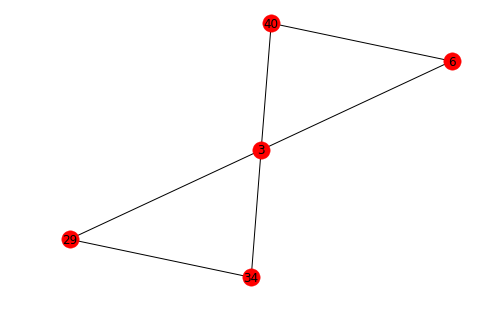

In [9]:
nx.draw(g_subgraph, with_labels=True)

We will discuss drawing networks in more detail below.

**Question** Write out the edge list representation of this graph.

[Answer together on the board]

### Other representations of the network

We discussed how there are different ways to represent a network in a computer. The edge list is very practical because many real networks are quite *sparse*, meaning that they have relatively few edges

**Question** Suppose there is a network of $n$ nodes, and that there can be at most one edge between any two nodes. What is the maximum number of edges that the network could have?

**Answer:** An undirected network with $n$ nodes can have at most $\frac{n \times (n-1)}{2}$ edges.

The edge list is a particularly convenient way of storing a description of a network in a file (or in memory) when the network is large and sparse.  Another way to store a network is as an *adjacency matrix*. The *adjacency matrix* is not too practical for large networks because the amount of memory it requires increases quickly with the number of nodes in the network. However, the adjacency matrix turns out to be convenient to work with mathematically, so many formal results rely upon it.

The adjacency matrix is a matrix -- i.e., it is an array of numbers, like a table. It is square, meaning that it has the same number of rows and columns. These rows and columns are ordered so that each id corresponds to one row and column.

Each entry in an adjacency matrix can be located by its coordinates: (row number, column number).  If an entry is 0, it means that there is no edge between the vertices corresponding to the row and column. If an entry is 1, then there is an edge between the vertices corresponding to the row and column.

[Example on board]

<BR>

**Question** Try to write the adjacency matrix for the subgraph shown above (we'll check our answer next).

[Answer here]

**Question** Of course, `networkx` will display the edge list and the adjacency matrix representations of the network for you. Check your answers to the previous two questions using the `edges` method and the `nx.adjacency_matrix` function.

In [10]:
g_subgraph.edges()

EdgeView([(40, 3), (40, 6), (34, 3), (34, 29), (3, 29), (3, 6)])

In [11]:
nx.adjacency_matrix(g_subgraph)

<5x5 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

In order to actually show the contents of the adjacency matrix (since we know, in this case, that it's not too big), we can use the `todense` method:

In [12]:
nx.adjacency_matrix(g_subgraph).todense()

matrix([[0, 0, 1, 0, 1],
        [0, 0, 1, 1, 0],
        [1, 1, 0, 1, 1],
        [0, 1, 1, 0, 0],
        [1, 0, 1, 0, 0]], dtype=int64)

There's the matrix -- but, it's a bit hard to interpret it without knowing which node id corresponds to which row and column. If you look at the [help file](https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.linalg.graphmatrix.adjacency_matrix.html) for `adjacency_matrix`, you will see that it says that, by default, it orders the rows/columns according to the results of `nodes()`. So we can interpret the matrix above by calling:

In [13]:
g_subgraph.nodes()

NodeView((40, 34, 3, 29, 6))

Check that the matrix you get makes sense by comparing it to the plot above.

### Plotting a network

As we saw above, `networkx` will help us draw a network using the `draw` function:

//anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


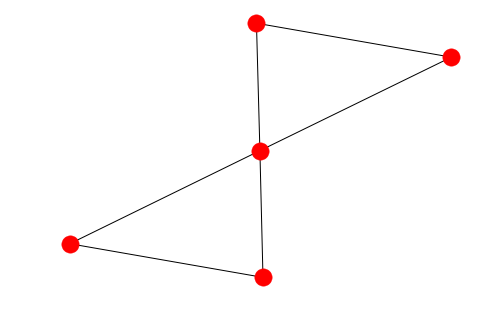

In [14]:
nx.draw(g_subgraph)

Now look at the help files for the `networkx` package and try to find at least three other ways to draw the network.<BR> 
[*Hint: try typing `nx.draw` and then push Tab; you should see a list with possible completions pop up.*]

Each time you make a new plot, read the help file and try to explain how this plot is made. (If you don't understand the help file, that is OK -- some if it goes beyond what we have discussed so far. Just do your best.)

//anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


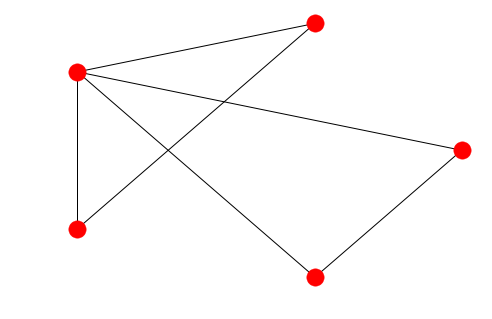

In [15]:
nx.draw_circular(g_subgraph)

//anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


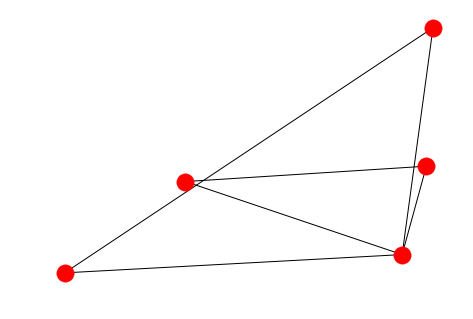

In [16]:
nx.draw_random(g_subgraph)

//anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


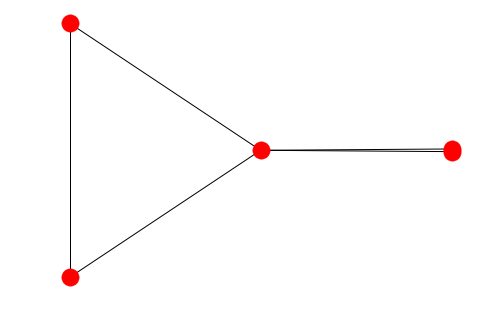

In [17]:
nx.draw_spectral(g_subgraph)

**Question** Now you have drawn a small network in four different ways. How similar are the different renderings of the network? If you were given two different drawings and someone asked you if they represented the same network, how would you try to answer them? How hard would it be?

[Answer here]

### The complete network

Remember that, so far, we have mostly been looking at a subgraph of the complete school network. This was helpful because it is easier to illustrate some network concepts with smaller networks. Now we will turn to the entire network.

**Question** Before we turn to the entire network, let's review: what are the nodes and what are the edges of this network?<BR>
*[Hint: if you have forgotten, look earlier in this lab where we described the format of the dataset]*

* nodes - [answer here]
* edges - [answer here]

**Answer** the nodes are schoolchildren and the edges are friendships or social connections between the children.

**Question** Now use the `draw` function to draw the complete school network. Do you notice anything distinctive about its structure? (Please keep in mind the definition of the network when answering this question -- i.e., remember what the nodes are and what the edges are.)

//anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


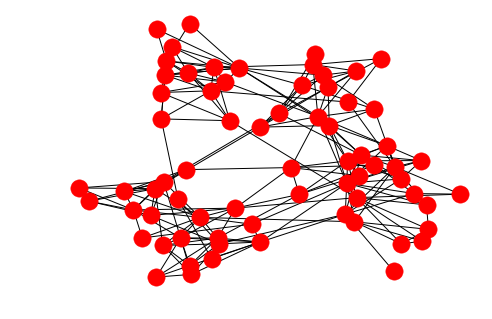

In [19]:
nx.draw(g)

**Question** Now use the three other drawing methods that you discovered above to produce different plots of this network.

//anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


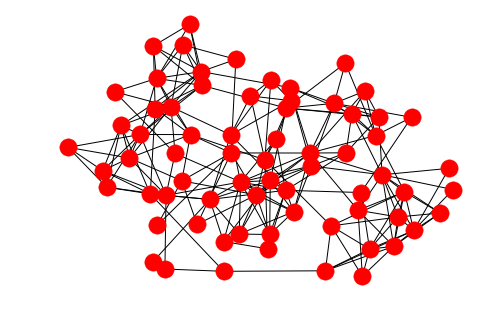

In [18]:
nx.draw_kamada_kawai(g)

//anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


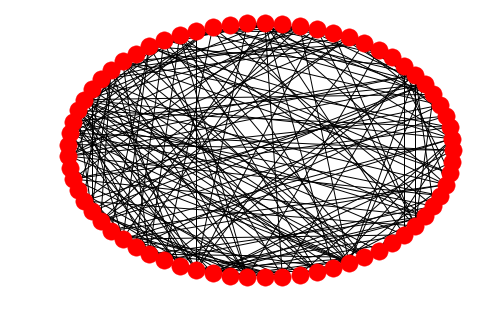

In [20]:
nx.draw_shell(g)

//anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


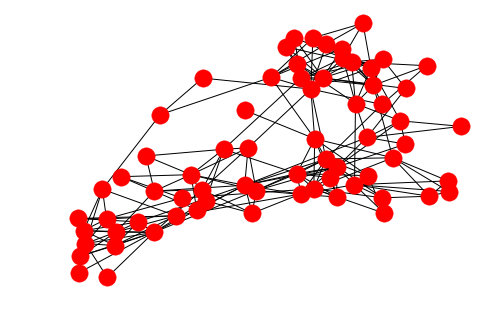

In [21]:
nx.draw_spring(g)

**Question** As its name suggests, `draw_random` draws the network with a random layout. You will get a different plot each time you call `draw_random`. Write a simple loop that will call `draw_random` 10 different times, producing 10 different random drawings of this network.<BR>
*[HINT: after each plot you draw in your loop, tell matplotlib that you want to start a new plot (rather than adding to the existing one) by calling `plt.figure()`]*

//anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


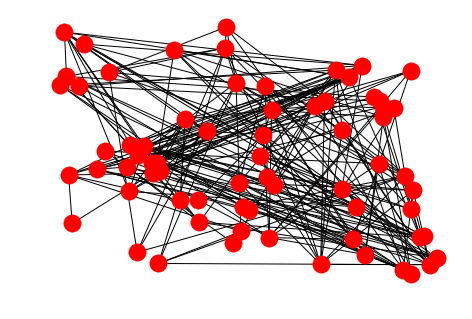

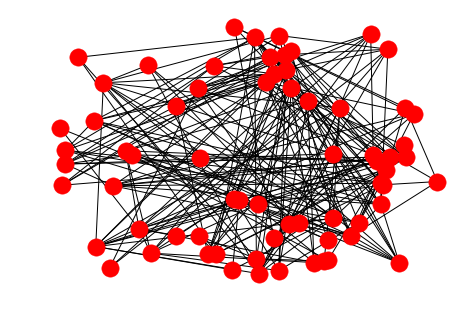

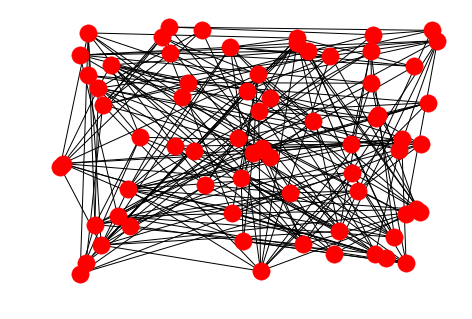

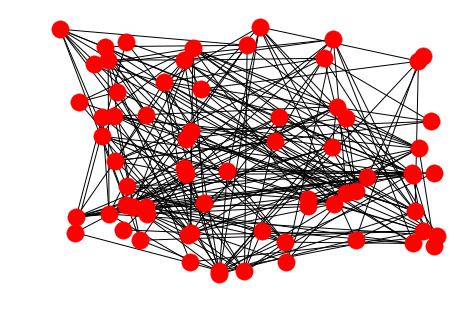

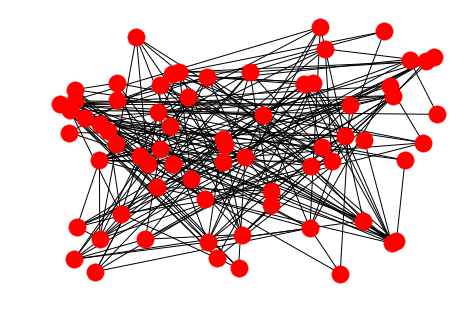

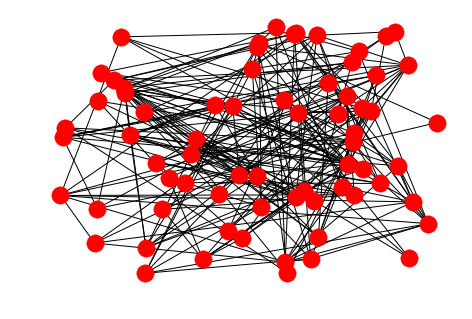

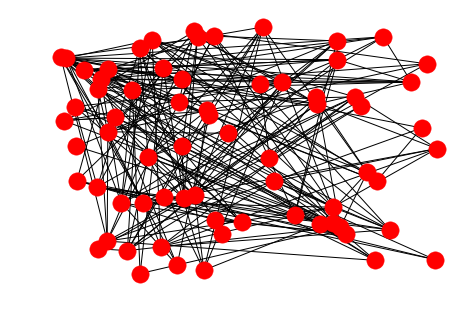

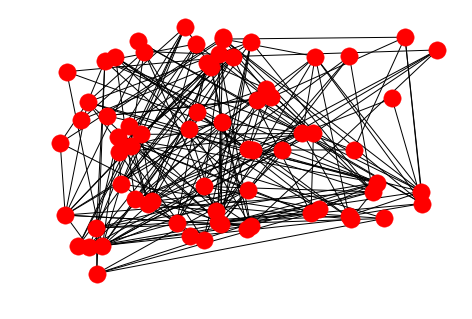

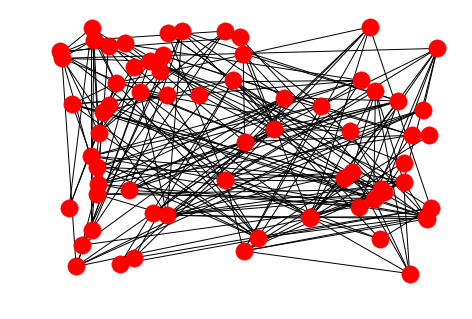

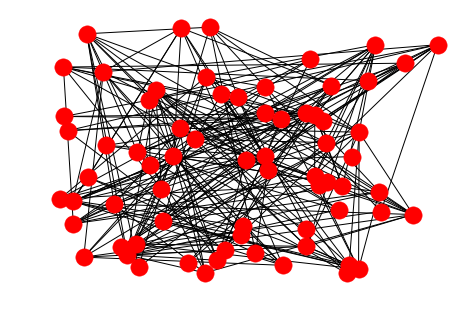

<Figure size 432x288 with 0 Axes>

In [22]:
for i in range(10):
    nx.draw_random(g)
    plt.figure()

**Question** Looking at the 10 random layout plots of the network that you just created, how similar or different are they? If someone gave you a drawing of a network and asked if it was the same as this network we are looking at, how hard or easy would it be to answer them?

[Answer here]

### Degree plots

In our very first class, we brainstormed a few of the quantitative ways that we could try to summarize the structure of a network. One of these ways was to look at the *degrees* in the network. The degree of a node in the network is the number of other nodes that it is connected to.

Now we will investigate the degrees in this school friendship network.

Think for a second about what the collection of degrees in a network tells us: it tells us, for each node, how connected that node is.  Often, we are interested in understanding how much that varies from node to node. For example, in some networks, it can be the case that every node has exactly the same degree; in other networks, there can be huge differences in the degrees of different nodes.

**Question** Remembering the definition of the network here (ie, what the nodes and edges are), please write a sentence that describes what would be true of the school if all of the nodes in this network had the same degree.

[Answer here]

**Answer** It would mean that all of the children had the same number of friends.

**Question** And what would be true of the school if some nodes in this network had very small degrees and some had very big degrees?

[Answer here]

**Answer** It would mean that the children had very different numbers of friends -- some are more popular or more social than others.

**Question** Based on your experience as a student in high school, do you think it is more likely that all of the nodes will have similar degrees, or do you think it is more likely that the nodes will vary a lot in their degrees?

[Answer here]

Now we will use the data to investigate this issue.

**Question** Create a Table called `g_degrees` that has two columns:
* `id` - has the id of each node in the network
* `degree` - has the degree of each node in the network

<BR>


In [23]:
g.degree

DegreeView({1: 3, 2: 9, 3: 4, 5: 4, 6: 5, 7: 7, 8: 10, 9: 9, 10: 4, 11: 3, 12: 1, 13: 5, 14: 7, 15: 6, 16: 9, 18: 7, 19: 4, 20: 9, 21: 7, 22: 3, 23: 9, 24: 5, 25: 6, 26: 7, 27: 8, 28: 3, 29: 10, 30: 7, 31: 9, 32: 4, 33: 12, 34: 14, 35: 8, 36: 10, 37: 5, 38: 8, 39: 3, 40: 8, 41: 3, 42: 6, 43: 9, 44: 6, 45: 5, 46: 8, 47: 4, 48: 6, 49: 5, 50: 5, 51: 13, 52: 7, 53: 4, 54: 9, 55: 2, 56: 6, 57: 2, 58: 8, 59: 5, 60: 11, 61: 11, 62: 2, 63: 2, 64: 6, 65: 7, 66: 11, 67: 4, 68: 6, 69: 9, 70: 3, 71: 3})

In [24]:
g_degrees = Table().with_columns([
    'id', g.nodes(),
    'degree', [d for (n,d) in g.degree] # this  gets list of degree values from the (node,degree) pairs
])

**Question** Now make a histogram of the degrees of the nodes in the network

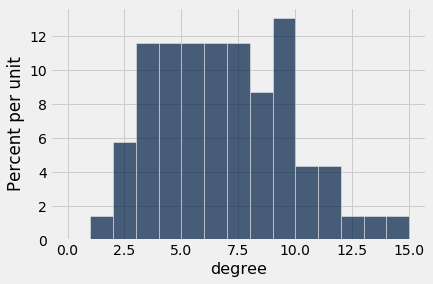

In [25]:
g_degrees.hist('degree', bins=np.arange(0, 16, 1))

**Question** How similar are the nodes' degrees? Does this match your prediction?

[Answer here]